# Hybrid Zero Shot Learning Approach

In [1]:
import pandas as pd
import numpy as np

<h2>Loading Pre-Trained Models</h2>

In [2]:
from transformers import AutoTokenizer, AutoModel

# Specify the model name for BERT4RE
model_name = "thearod5/bert4re"  # Replace with the correct model name or path if needed

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert4re = AutoModel.from_pretrained(model_name)

print("BERT4RE loaded successfully.")

Some weights of RobertaModel were not initialized from the model checkpoint at thearod5/bert4re and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT4RE loaded successfully.


<h2>Data Preprocessing</h2>

In [3]:
# Loading in promise dataset
df = pd.read_csv("datasets/promise.csv")

df.head()

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,PE
1,The application shall match the color of the s...,LF
2,If projected the data must be readable. On a...,US
3,The product shall be available during normal b...,A
4,If projected the data must be understandable....,US


<h3>Re-Labeling</h3>

In [4]:
# Making dataset binary between functional & non-functional requirements

df.loc[df['TYPE'] != 'F', 'TYPE'] = 'NF' # Locating all values that do not equal 'F' and changing them to 'NF'

df.head(20)

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,NF
1,The application shall match the color of the s...,NF
2,If projected the data must be readable. On a...,NF
3,The product shall be available during normal b...,NF
4,If projected the data must be understandable....,NF
5,The product shall ensure that it can only be a...,NF
6,The product shall be intuitive and self-explan...,NF
7,The product shall respond fast to keep up-to-d...,NF
8,The system shall have a MDI form that allows f...,F
9,The system shall display Events in a vertical ...,F


<h3>Lowercasing</h3>

In [5]:
df['INPUT'] = df['INPUT'].str.lower()

df.head()

,INPUT,TYPE
0,the system shall refresh the display every 60 ...,NF
1,the application shall match the color of the s...,NF
2,if projected the data must be readable. on a...,NF
3,the product shall be available during normal b...,NF
4,if projected the data must be understandable....,NF


<h3>Stopword Removal</h3>

In [6]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return filtered_text

# Apply stopword removal to the DataFrame column
df['INPUT'] = df['INPUT'].apply(remove_stopwords)

df.head()

,INPUT,TYPE
0,system shall refresh display every 60 seconds.,NF
1,application shall match color schema set forth...,NF
2,projected data must readable. 10x10 projection...,NF
3,product shall available normal business hours....,NF
4,projected data must understandable. 10x10 proj...,NF


<h3>Punctuation Removal<h3>

In [7]:
import string

# Replacing percent symbol to string
df['INPUT'] = df['INPUT'].str.replace('%', ' percent')

# Remove punctuation from a specific column (e.g., 'Column1')
df['INPUT'] = df['INPUT'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

df.head(20)

,INPUT,TYPE
0,system shall refresh display every 60 seconds,NF
1,application shall match color schema set forth...,NF
2,projected data must readable 10x10 projection ...,NF
3,product shall available normal business hours ...,NF
4,projected data must understandable 10x10 proje...,NF
5,product shall ensure accessed authorized users...,NF
6,product shall intuitive selfexplanatory 90 pe...,NF
7,product shall respond fast keep uptodate data ...,NF
8,system shall mdi form allows viewing graph dat...,F
9,system shall display events vertical table time,F


<h3>Dataset Proportion</h3>

In [8]:
# Count the number of F and NF in the dataset
label_counts = df['TYPE'].value_counts()

print("Number of Functional (F) requirements:", label_counts.get('F', 0))
print("Number of Non-Functional (NF) requirements:", label_counts.get('NF', 0))

Number of Functional (F) requirements: 255
Number of Non-Functional (NF) requirements: 370


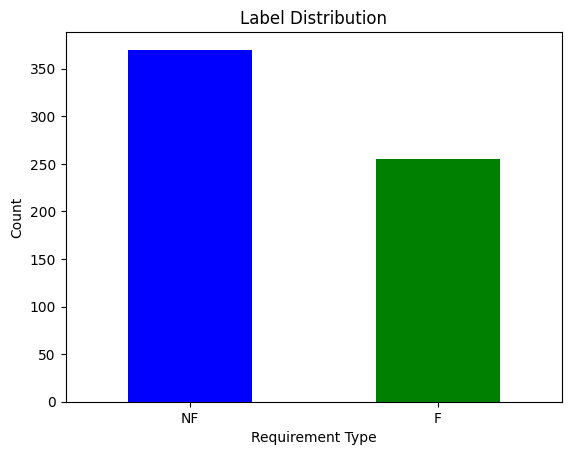

In [9]:
import matplotlib.pyplot as plt

# Plot a bar chart of label distribution
label_counts.plot(kind='bar', color=['blue', 'green'])
plt.title("Label Distribution")
plt.xlabel("Requirement Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

<h2>BERT4RE Fitting<h2>

<h3>Label Descriptions</h3>

In [ ]:
label_descriptions = {
    "functional": {
        "sentences": [
            "Represents a specific behavior or feature that the system is required to perform.",
            "Describes actions the software must execute to fulfill business processes or user needs.",
            "Defines explicit functionalities that contribute directly to achieving system objectives.",
            "Focuses on 'what' the system does, including data processing, computations, and workflows.",
            "Specifies system features that interact with users, data, or external systems to deliver value.",
            "Describes user-requested tasks or operations that align with the intended application scope.",
            "Outlines step-by-step actions or features essential for completing user tasks or business goals."
        ],
        "words": [
            "behavior, feature, system actions, operations, user needs, data processing",
            "user interactions, workflows, computations, system objectives, explicit functionality",
            "data inputs, data outputs, business processes, user tasks, system operations"
        ]
    },
    "non_functional": {
        "sentences": [
            "Defines the standards and conditions under which the system operates to ensure quality.",
            "Specifies criteria such as performance, security, and usability that guide system operations.",
            "Focuses on 'how' the system performs its tasks, including efficiency and reliability constraints.",
            "Outlines measurable attributes like scalability, availability, and maintainability.",
            "Describes system properties that ensure operational consistency and user satisfaction.",
            "States operational benchmarks for system behavior, such as latency, error tolerance, or throughput.",
            "Defines quality-of-service metrics and compliance standards the system must achieve."
        ],
        "words": [
            "performance, usability, reliability, scalability, efficiency, quality standards",
            "latency, error tolerance, throughput, security, compliance, maintainability",
            "availability, consistency, system benchmarks, operational standards, quality metrics"
        ]
    }
}

<h3>BERT4RE Label Embeddings</h3>

In [22]:
import torch

# Function to generate embeddings
def generate_embeddings(text_list, tokenizer, model):
    embeddings = []
    for text in text_list:
        # Tokenize text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        
        # Get model output
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract the CLS token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
        embeddings.append(cls_embedding)
    return torch.stack(embeddings)

# Generate embeddings for functional and non-functional requirements
functional_label_embeddings_full = generate_embeddings(label_descriptions["functional"]["full_sentences"], tokenizer, bert4re)
functional_label_embeddings_comma = generate_embeddings(label_descriptions["functional"]["comma_separated"], tokenizer, bert4re)

non_functional_label_embeddings_full = generate_embeddings(label_descriptions["non_functional"]["full_sentences"], tokenizer, bert4re)
non_functional_label_embeddings_comma = generate_embeddings(label_descriptions["non_functional"]["comma_separated"], tokenizer, bert4re)

<h3>BERT4RE Requirements Embeddings<h3>

In [36]:
import torch.nn.functional as F

# Combine all label embeddings and assign classes
all_label_embeddings = torch.cat([functional_label_embeddings_full, non_functional_label_embeddings_full], dim=0)
label_classes = [1] * len(functional_label_embeddings_full) + [0] * len(non_functional_label_embeddings_full)

# Generate embeddings for requirements from df['INPUT']
requirement_embeddings = generate_embeddings(df['INPUT'].tolist(), tokenizer, bert4re)

# Function to classify requirements based on cosine similarity
def classify_requirements(requirement_embeddings, label_embeddings, label_classes):
    classifications = []
    similarities_list = []  # Store similarity scores
    for req_embedding in requirement_embeddings:
        similarities = F.cosine_similarity(req_embedding.unsqueeze(0), label_embeddings, dim=1)
        best_match_idx = torch.argmax(similarities).item()
        classifications.append(label_classes[best_match_idx])
        similarities_list.append(similarities.tolist())  # Add all similarities for this requirement
    return classifications, similarities_list

# Classify the requirements
requirement_classes, similarities = classify_requirements(requirement_embeddings, all_label_embeddings, label_classes)

# Map numerical labels to human-readable labels
class_map = {0: "F", 1: "NF"}
classified_results = [class_map[cls] for cls in requirement_classes]

# Display results
for i, req in enumerate(df['INPUT']):
    print(f"Requirement: \"{req}\" -> Classified as: {classified_results[i]}")
    print(f"Similarities: {similarities[i]}")
    print("-" * 80)



Requirement: "system shall refresh display every 60 seconds" -> Classified as: F
Similarities: [0.9030494689941406, 0.9444849491119385, 0.9321112036705017, 0.9372141361236572, 0.9351220726966858, 0.9467675685882568, 0.9377607703208923, 0.9371618032455444, 0.9373236894607544, 0.9399780035018921, 0.9316490888595581, 0.943717360496521, 0.9442096948623657, 0.9472135901451111]
--------------------------------------------------------------------------------
Requirement: "application shall match color schema set forth department homeland security" -> Classified as: NF
Similarities: [0.8759535551071167, 0.9645841717720032, 0.9730759859085083, 0.9499024152755737, 0.9290740489959717, 0.9679102301597595, 0.9613440036773682, 0.9375252723693848, 0.9237619042396545, 0.9639866352081299, 0.9569463729858398, 0.9723237752914429, 0.9550619125366211, 0.9641165137290955]
--------------------------------------------------------------------------------
Requirement: "projected data must readable 10x10 project

<h2>Model Evaluation<h2>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Example true labels and predicted labels
# Replace with your actual labels
true_labels_text = df['TYPE'] # Replace with your true labels
label_mapping = {'F': 0, 'NF': 1}  # Map 'F' to 1 and 'NF' to 0
true_labels = [label_mapping[label] for label in true_labels_text]

# Calculate accuracy
accuracy = accuracy_score(true_labels, requirement_classes)

# Generate classification report
report = classification_report(
    true_labels,
    requirement_classes,
    target_names=["F", "NF"],  # Display "F" for 0 and "NF" for 1
)

# Print accuracy and classification report
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)

Accuracy: 0.5760

Classification Report:
              precision    recall  f1-score   support

           F       0.47      0.37      0.42       255
          NF       0.62      0.72      0.67       370

    accuracy                           0.58       625
   macro avg       0.55      0.54      0.54       625
weighted avg       0.56      0.58      0.57       625

